# Import libraries

# IA Team 7 
* Gabriela Patricia Viloria Rojas 1945316
* Yairi Daniela Valdez Cortes 1954846
* Miriam Adriana Zavala Gongora 1902144
* Itzel de los Angeles Lopez Cuevas 2077516
* Laura Carolina Garza Lozano 2077606 

# Import libraries

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
print('Done')



Done


# Load dataset and turn labels into numeric data

In [2]:
import os

# Define the path to the dataset directory
dataset_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"

# Get the list of image files
image_files = []
labels = []

# Iterate over the directories
for class_name in ['benign', 'malignant', 'normal']:
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image_files.append(image_path)
        labels.append(class_name)

# Convert labels to numerical values
from tensorflow.keras.utils import to_categorical

# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
# Get the original class labels from the label encoder
original_labels = label_encoder.classes_

# Convert labels to one-hot encoded format
labels = to_categorical(labels)


# Print the mapping between numerical values and original labels
for numerical_value, original_label in enumerate(original_labels):
    print(f"Numerical Value: {numerical_value}, Original Label: {original_label}")

print('Done')

Numerical Value: 0, Original Label: benign
Numerical Value: 1, Original Label: malignant
Numerical Value: 2, Original Label: normal
Done


Shape of labels and how many images in the array, in this case there are 3 labels and 1578 images

In [3]:
print(labels.shape)
print(len(image_files))

(1578, 3)
1578


# Split data into training and test 
30% of dataset will be test images

In [4]:

X_train, X_test, y_train, y_test = train_test_split(image_files, labels, test_size=0.3, random_state=42, stratify=labels)
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))

1104 1104
474 474


# Image preprocessing
Images are resized and converted to grayscale (images are apparently grayscale but they actually are RGB, so they will be converted). They are converted using Pillow library. The pixel values are also normalized in a scale of 0 to 1. Images are then loaded to their corresponding arrays.

In [5]:
# Define a function to load and preprocess the images
def load_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((150, 150))
#this converts the image to BW
    image = image.convert('L') 
    image = np.array(image)
    image = image.reshape((150, 150, 1))
#image normalization
    image = image.astype('float32') / 255.0
    return image

X_train = [str(image_path) for image_path in X_train]
X_test = [str(image_path) for image_path in X_test]

# Load and preprocess the training images and labels
X_train = [load_preprocess_image(image_path) for image_path in X_train]
X_train = np.array(X_train)
y_train= np.array(y_train)

# Load and preprocess the testing images and labels
X_test= [load_preprocess_image(image_path) for image_path in X_test]
X_test = np.array(X_test)
y_test = np.array(y_test)

Now after preprocessing, check the size and color channels of images, as well as the labels using the shape function. Note that the dataset features images with only the tumor higlighted in white in a black background, these are refered to as masks which can be used to overlay the images. However we will experiment with using these images as training too.

(1104, 150, 150, 1) (1104, 3)
(474, 150, 150, 1) (474, 3)


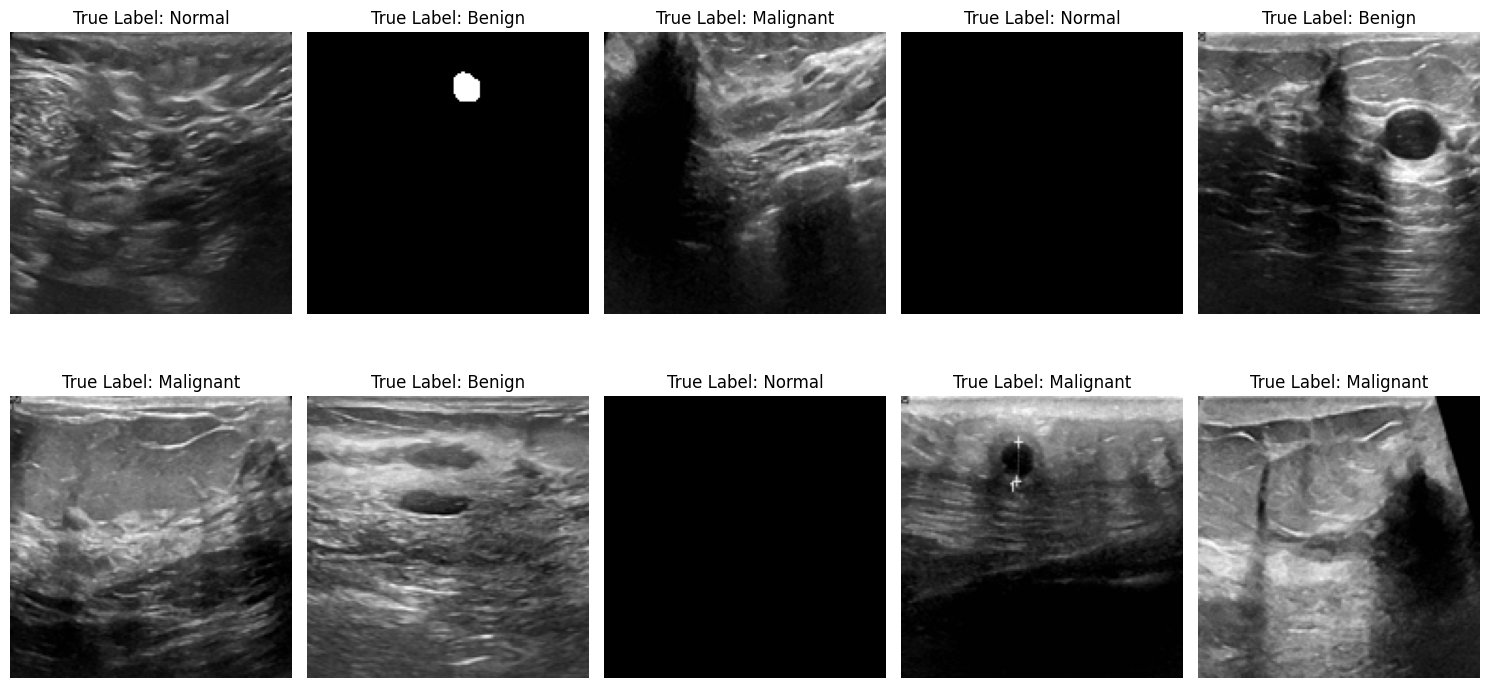

In [6]:
#Check size and color channels of images and labels
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

#Show images
images = X_test[:10] 
labels = y_test[:10]  

# Convert them to class indices
class_indices = np.argmax(labels, axis=1)

# Define class labels 
class_labels = ['Benign', 'Malignant', 'Normal']

num_rows = 2
num_cols = len(images) // num_rows

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Flatten the axes 
axes = axes.flatten()

# Display images with labels in the subplots
for i in range(len(images)):
    ax = axes[i]
    ax.imshow(images[i], cmap='gray')  # Assuming images are 2D arrays (grayscale)
    ax.set_title(f'True Label: {class_labels[class_indices[i]]}')
    ax.axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig('/kaggle/working/images_with_labels.png')
plt.show() 


# Initialize, train and compile model
First add convolutional laters, the activation function used is relu and the input shape is specified. The resolution used is 150x150 and the images are in grayscale, so the last parameter is 1.
We use categorical crossentropy as the loss function, which is suitable for multi-class classification problems. We are also using softmax in the output layer because we want to use probability.
The dropout layers are used to prevent overfitting, also the keras callback Early stopping was used to stop the training if there was no improvement in the accuracy by 2 epochs.

In [7]:
# Initialize the model
model = Sequential()

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Add more convolutional layers
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Add dense layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the EarlyStopping callback to monitor accuracy
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights = 'True')

# Train the model
#model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.1)
history = model.fit(X_train, y_train, batch_size=32, epochs=15, validation_split=0.1, callbacks=[early_stopping]) 

Epoch 1/15
32/32 [==============================] - 36s 1s/step - loss: 0.8896 - accuracy: 0.5388 - val_loss: 0.8049 - val_accuracy: 0.6216
Epoch 2/15
32/32 [==============================] - 34s 1s/step - loss: 0.8327 - accuracy: 0.5861 - val_loss: 0.7750 - val_accuracy: 0.6757
Epoch 3/15
32/32 [==============================] - 33s 1s/step - loss: 0.7608 - accuracy: 0.6757 - val_loss: 0.7178 - val_accuracy: 0.6577
Epoch 4/15
32/32 [==============================] - 33s 1s/step - loss: 0.7189 - accuracy: 0.6939 - val_loss: 0.7843 - val_accuracy: 0.6757
Epoch 5/15
32/32 [==============================] - 33s 1s/step - loss: 0.5925 - accuracy: 0.7261 - val_loss: 0.9051 - val_accuracy: 0.7477
Epoch 6/15
32/32 [==============================] - 33s 1s/step - loss: 0.5364 - accuracy: 0.7573 - val_loss: 0.7466 - val_accuracy: 0.7207
Epoch 7/15
32/32 [==============================] - 33s 1s/step - loss: 0.5997 - accuracy: 0.7422 - val_loss: 0.7735 - val_accuracy: 0.7387
Epoch 8/15
32/32 [==

# Plot accuracy results

In [15]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print('Training Accuracy:', train_accuracy,"Train loss",train_loss)
print('Testing Accuracy:', test_accuracy,"Test Loss",test_loss)



Training Accuracy: 0.8496376872062683 Train loss 0.3834382891654968
Testing Accuracy: 0.7637130618095398 Test Loss 0.6645249128341675


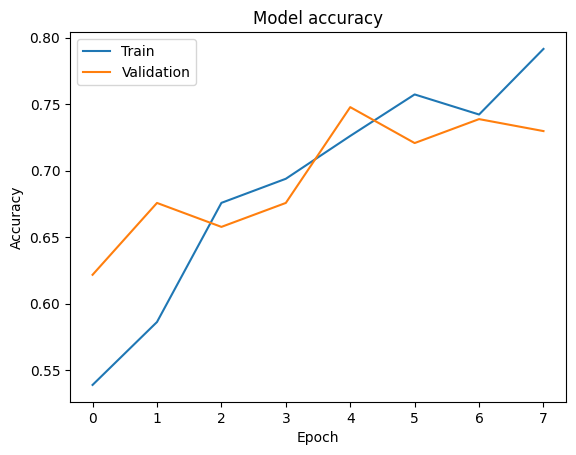

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('/kaggle/working/accuracy_plot.png')
plt.show()



# Predictions

1/1 [==============================] - 0s 46ms/step


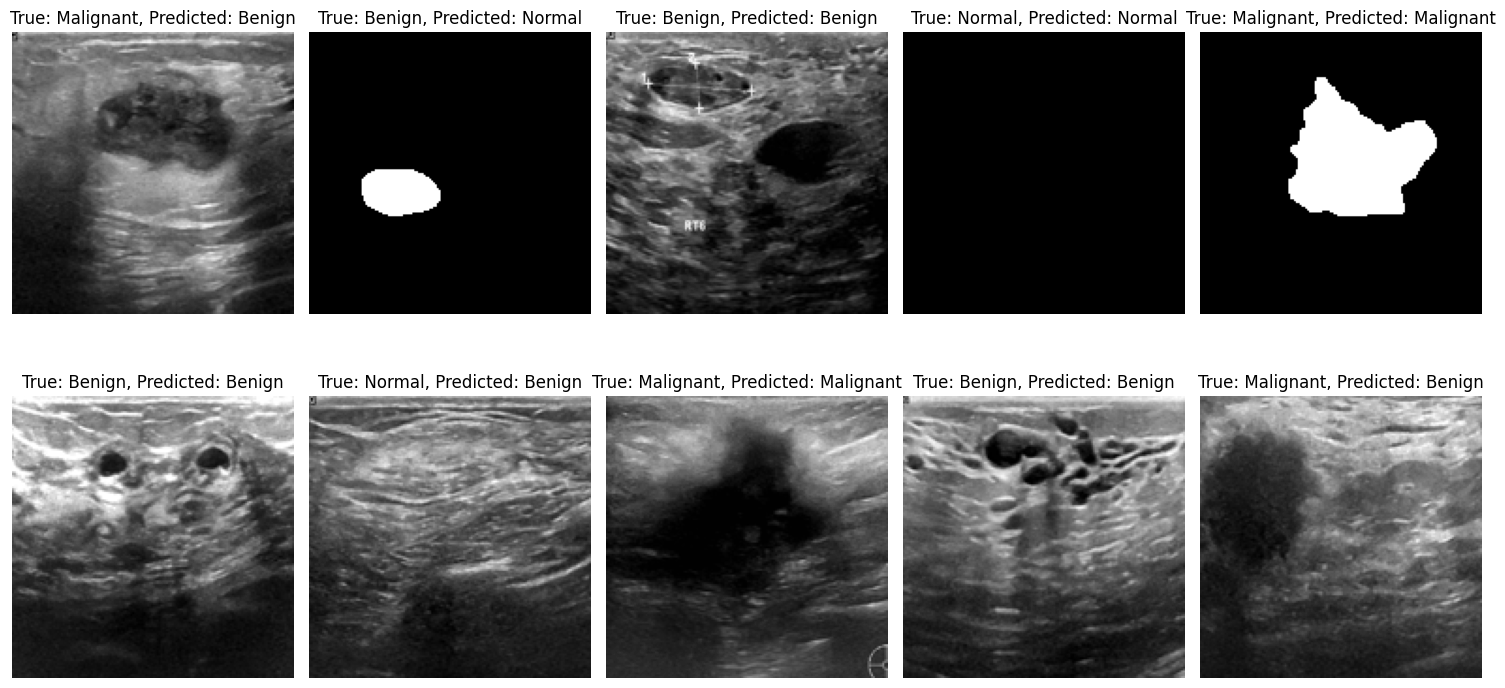

In [28]:
num_images_to_display = 10
selected_indices = np.random.choice(len(X_test), num_images_to_display, replace=False)
class_names = ['Benign', 'Malignant', 'Normal']
# Create a subplot grid
num_rows = 2
num_cols = num_images_to_display // num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Flatten the axes 
axes = axes.flatten()

# Display predictions for the selected test images
for i, index in enumerate(selected_indices):
    # Get the test image and true label
    test_image = X_test[index]
    true_label = np.argmax(y_test[index])

    # Preprocess the image
    img_array = np.expand_dims(test_image, axis=0)
    
    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    
    # Display the image
    ax = axes[i]
    ax.imshow(test_image.reshape((150, 150)), cmap='gray') 
    ax.set_title(f'True: {class_names[true_label]}, Predicted: {class_names[predicted_class]}')
    ax.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/prediction.png')
plt.show()


# Save model

In [11]:
#model.save('/kaggle/working/breast_model')


In [12]:
#!zip -r file.zip /kaggle/working



In [13]:
#!ls


In [14]:
#from IPython.display import FileLink
#FileLink(r'file.zip')